In [1]:
pwd

'/Users/spangher/Projects/berkeley-research/conditional-information-retrieval/notebooks'

In [2]:
ls ../

README.md                g++@                     requirements.txt
baseline_queries/        helper_functions/        source_retriever/
data/                    notebooks/               source_summaries/
env.yaml                 press_release_summaries/ venv/


In [3]:
import re
import ast
import pyperclip
import pprint
import os
from together import Together

client = Together(api_key=open('/Users/spangher/.togetherai-usc-key.txt').read().strip())
def query_together(prompt, client=client):
    response = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        messages=[{
                    "role": "system",
                    "content": "You are an experienced journalist."
                },
                {
                    "role": "user",
                    "content": prompt
                }],
        max_tokens=1048,
        temperature=0.1,
        top_p=0.7,
        top_k=50,
        repetition_penalty=1,
        stop=["<|eot_id|>","<|eom_id|>"],
    )
    return response.choices[0].message.content

In [4]:
import pandas as pd 
from unidecode import unidecode

df_summaries = pd.read_csv('../press_release_summaries/pr_summary.csv')
df_article_mapper = pd.read_csv('../press_release_summaries/news_articles_covering_the_same_press_releases.csv', index_col=0)
df_pr_full_text = pd.read_csv('../press_release_summaries/pr_full_text.csv', index_col=0)
df_article_full_text = pd.read_csv('../press_release_summaries/articles_full_text.csv', index_col=0)

In [106]:
data_dir = '../../../bloomberg-research/press-releases/data/s_p_500_backlinks'
source_df = pd.read_json(f'{data_dir}/full-source-scored-data.jsonl.gz', lines=True, compression='gzip')

In [115]:
slim_source_df = source_df.loc[lambda df: df['article_url'].isin(df_article_mapper['URL'])]

In [119]:
# slim_source_df['attributions'].apply(set).apply(list).explode()

In [120]:
slim_source_df.to_json('../press_release_summaries/sources_in_articles.jsonl', lines=True, orient='records')

In [126]:
((60_000 / 50 * 5) / 60) / 24

4.166666666666667

In [48]:
PRESS_RELEASE_SUMMARY_PROMPT = """Here is press release:

```{press_release_text}```

Summarize the facts in this press release in 3-4 sentences. Return only the summary.
"""

ANGLE_IDENTIFICATION = """Here is the summary of a press-release:

```{pr_summary}```

Here is a news article written based off of this press release. 
The news article is messy and a lot of the text is simply on the page at the time of the scrape and has nothing to do with the press release.
Ignore all this junk text.

```{article_text}```

Describe the unique angle this news article takes on this press release. Contrast it with the original story shared in the press release. 

An angle could be:
* A bigger picture story.
* A story that mixes in a particular topic that wasn't focused on in the original story lead.
* An analysis that tries to go behind the scenes.
* Something else.

Return only the summary.
"""

QUESTION_IDENTIFICATION = """Here is a news article:

```{news_article}```

Identify the initial reason why the journalist started investigating this topic (i.e. the story lead) and the angle they started with.
Don't include any information the journalist learned after investigating further. 
State your entire response from the viewpoint of the journalist in 1-2 sentences. Be specific and concise. Ask a question.
"""
# , using place names, people names and concepts that were part of your initial lead. 

# Test Question Generation

In [49]:
prompt = QUESTION_IDENTIFICATION.format(news_article=df_article_full_text['article_text'].iloc[4])
r = query_together(prompt)

In [50]:
r

"I started investigating this story because I noticed that despite the ongoing pandemic and economic challenges, the US stock market was set to wrap up 2021 with a third straight year of growth, with major indexes posting double-digit gains. What's behind this puzzling strength in the markets, and how are investors looking past the uncertainty and risks posed by the pandemic?"

In [40]:
r

'I started investigating this story after learning that the California Department of Financial Protection and Innovation announced the official closure of First Republic Bank on Monday, making it the third commercial bank to fail in recent months. My initial angle was to explore the implications of this bank failure on the local community, particularly in Newport Beach where First Republic Bank had a branch. What does this closure mean for the customers and employees of the Newport Beach branch, and how will it affect the local economy?'

In [25]:
r

"What sparked my investigation was the sudden closure of First Republic Bank, a major commercial bank, and I wondered what this meant for its customers and the local community, particularly in Newport Beach where I cover news. I decided to take an angle of how this closure would impact the bank's existing customers and branches, and what the takeover by JPMorgan Chase Bank would entail. Would the bank's failure have a ripple effect on the local economy and how would customers be affected?"

# Test Angle Identification

In [6]:
from tqdm.auto import tqdm

In [ ]:
num_prs = 10

# all_news_angles = []
for _, (pr_url, press_release_text) in tqdm(df_pr_full_text.sample(num_prs).iterrows(), total=num_prs):
    prompt = PRESS_RELEASE_SUMMARY_PROMPT.format(press_release_text=press_release_text)
    pr_summary = query_together(prompt)
    article_urls_covering_pr = (
        df_article_mapper
             .loc[lambda df: df['Target URL'] == pr_url][['URL', 'Target URL']]
            ['URL'].tolist()
    )
    articles_covering_pr = df_article_full_text.loc[lambda df: df['article_url'].isin(article_urls_covering_pr)]
    for _, (article_url, article_text) in tqdm(articles_covering_pr.iterrows(), total=len(articles_covering_pr)):
        prompt = ANGLE_IDENTIFICATION.format(pr_summary=pr_summary, article_text=article_text)
        news_angle = query_together(prompt)
        all_news_angles.append({
            'pr_url': pr_url,
            'pr_summary': pr_summary,
            'news_url': article_url,
            'news_angle': news_angle
        })

In [174]:
pd.DataFrame(all_news_angles)

,pr_url,pr_summary,news_url,news_angle
0,www.sempra.com/socalgas-seeks-offer-renewable-...,SoCalGas has proposed a program to offer custo...,www.vox.com/energy-and-environment/2020/2/14/2...,The unique angle this news article takes on th...
1,www.sempra.com/socalgas-seeks-offer-renewable-...,SoCalGas has proposed a program to offer custo...,www.theguardian.com/us-news/2019/jul/26/us-nat...,The unique angle of this news article is an in...
2,www.sempra.com/socalgas-seeks-offer-renewable-...,SoCalGas has proposed a program to offer custo...,www.theguardian.com/us-news/2019/jul/26/us-nat...,The unique angle of this news article is an in...
3,www.micron.com/about/about-the-convey-computer...,"Micron Technology, Inc. has acquired Convey Co...",www.prweb.com/releases/convey/memcached/prweb1...,This news article does not take a unique angle...
4,www.micron.com/about/about-the-convey-computer...,"Micron Technology, Inc. has acquired Convey Co...",www.prweb.com/releases/convey_computer/first_c...,This news article takes a unique angle by focu...
...,...,...,...,...
151,blog.google/products/news/new-google-news-ai-m...,"Google has launched an all-new Google News, a ...",www.bbc.co.uk/news/technology-44045424,The unique angle of this news article is that ...
152,news.bms.com/news/details/2023/Basketball-Lege...,Basketball legend Kareem Abdul-Jabbar has part...,www.blackenterprise.com/kareem-abdul-jabbar-pa...,The unique angle of this news article is a per...
153,news.bms.com/news/details/2023/Basketball-Lege...,Basketball legend Kareem Abdul-Jabbar has part...,dailycaller.com/2023/02/17/kareem-abdul-jabbar...,The unique angle of this news article is a per...
154,www.ge.com/research/newsroom/ge-research-and-c...,GE Research has been awarded a project by DARP...,fortune.com/2021/04/16/mrna-vaccines-covid-mod...,"Unfortunately, there is no unique angle in thi..."


# Test Angle summarization in keywords

In [175]:
ANGLE_SUMMARY_PROMPT = """
You will receive a sentence summarizing the angle a news story took. Your task is to identify a generalizable label that can characterize the angle.
The label must be as generalizable as possible and should not be topic-specific.

{definitions}

[Examples]
Example 1:

Angle: "The unique angle of this news article is that it uses the Goldman Sachs settlement as a segue to discuss the upcoming earnings reports of three big banks (Goldman Sachs, Morgan Stanley, and Bank of New York Mellon) and how they will be affected by the current market turmoil, rather than focusing solely on the settlement itself. The article provides a bigger picture story, analyzing the potential impact of the settlement on Goldman Sachs' earnings and comparing it to the performance of other banks in the industry. This angle is distinct from the original press release, which simply announced the settlement and its terms."
Your response: 
"Big Picture": This angle zooms out and looks at the news event in a broader context, by viewing several banks at the same time. It aims to describe a larger phenomenon.

Example 2:
Angle: "This news article takes a unique angle by using the Goldman Sachs settlement as a springboard to explore the broader theme of the "establishment" and its perceived corruption, cronyism, and influence peddling in Washington and on Wall Street. The article weaves together various narratives, including the 2016 presidential election, the revolving door between government and finance, and the perceived disconnect between the powerful elite and ordinary Americans. This angle contrasts with the original press release, which simply reported on the settlement agreement between Goldman Sachs and the government. The article\'s focus on the larger cultural and societal implications of the settlement adds depth and context to the story, making it a more nuanced and thought-provoking piece."
Your response:
"Political Intersectionality": This angle explores the news event in the context of political backdrop, what it symbolizes about a larger politcal culture.

Example 3:
Angle: "The unique angle of this news article is that it provides a more in-depth analysis of the settlement and its implications, rather than just reporting the facts of the agreement. The article also provides context about the background of the case, mentioning the financial crisis and the collapse of the US housing market, and highlights the impact of the settlement on Goldman Sachs' earnings. Additionally, the article mentions the decline in Goldman Sachs' profit in the third quarter of 2015, which is not mentioned in the original press release. Overall, the article takes a more narrative approach, trying to tell a story around the settlement rather than just reporting the facts."
Your response:
"Deeper Context": This angle provides a deeper historical background.


[Instructions]
Again, determine a generalizable label for the angle.

Each label must reflect a SINGLE feature instead of a combination of features.
If you add a new label, add a SHORT GENERAL LABEL and a DESCRIPTION OF THAT LABEL.
If the sentence is an error, return "Error". 
Return in the same format as the examples: "LABEL": DESCRIPTION. Please feel free to add a new label if it helps describe an angle.


Now it's your turn. Here's an angle:

[Angle]
```{angle}```

Your response:
"""

In [179]:
all_angle_summaries = []

In [180]:
for a in tqdm(all_news_angles):
    prompt = ANGLE_SUMMARY_PROMPT.format(angle=a['news_angle'], definitions="")
    r = query_together(prompt)
    all_angle_summaries.append(r)

  0%|          | 0/156 [00:00<?, ?it/s]

In [182]:
all_news_angles_df = pd.DataFrame(all_news_angles)

In [184]:
all_news_angles_df['angle_keyword_summaries'] = all_angle_summaries

In [187]:
all_news_angles_df.to_csv('cache/2024-08-27__angle-summaries.csv')

In [202]:
all_news_angles_df['angle_keywords'] = (all_news_angles_df['angle_keyword_summaries']
     .str.split(':')
     .str.get(0)
     .str.strip()
                                        
)

In [210]:
keywords = all_news_angles_df['angle_keywords'].value_counts()

In [222]:
(all_news_angles_df
     .loc[lambda df: df['angle_keywords'] == keywords.index[1]]
     [['news_angle', 'angle_keyword_summaries', 'angle_keywords']]
     .iloc[3]
     .to_dict()
)

{'news_angle': 'The unique angle of this news article is that it frames the Netflix-Nickelodeon partnership as a competitive move against Disney Plus, which had just launched and announced 10 million subscribers on its first day. This angle adds a bigger picture story to the original press release, which simply announced the partnership and its goals to produce original animated content. The article uses the partnership as a way to discuss the broader streaming wars and the competition for subscribers, whereas the original press release focused solely on the partnership and its creative goals.',
 'angle_keyword_summaries': '"Competitive Framing": This angle views the news event in the context of competition, positioning it as a strategic move in a larger rivalry.',
 'angle_keywords': '"Competitive Framing"'}

In [224]:
all_news_angles_df['angle_keywords'].drop_duplicates()

0        "Skeptical Scrutiny"
1         "Behind the Facade"
2         "Critical Scrutiny"
3              "Non Sequitur"
4            "Technical Dive"
                ...          
140    "Comparative Analysis"
143           "Brief Mention"
146             "Proxy Issue"
148             "Local Focus"
154                    "None"
Name: angle_keywords, Length: 69, dtype: object

In [228]:
pd.options.display.max_colwidth = 200

In [236]:
all_news_angles_df.groupby('pr_url')['angle_keyword_summaries'].aggregate(list).apply(lambda x: list(set(x))).iloc[0]

['"Insider Perspective": This angle adds depth to the story by incorporating quotes and insights from key individuals involved, providing a more personal and nuanced understanding of the event.',
 '"Competitive Framing": This angle views the news event as a strategic move within a competitive landscape, highlighting the relationships and rivalries between key players.',
 '"Competitive Context": This angle frames the news event in the context of competition, highlighting how it relates to and affects other players in the same field.',
 '"Competitive Framing": This angle views the news event in the context of competition, positioning it as a strategic move in a larger rivalry.',
 '"Speculative Extension": This angle takes a piece of information and uses it as a starting point to explore a hypothetical or potential development, rather than focusing on the facts of the original story.',
 '"Competitive Context": This angle frames the news event in the context of competition, highlighting ho

In [241]:
from transformers import AutoTokenizer

In [243]:
tok = AutoTokenizer.from_pretrained('gpt2')

In [249]:
categories = (
    all_news_angles_df
        [['angle_keyword_summaries', 'angle_keywords']]
        .drop_duplicates('angle_keywords')
        ['angle_keyword_summaries']
        .pipe(lambda s: '\n\n'.join(s))
         # .groupby('pr_url')['angle_keywords']
         # .aggregate(list).apply(lambda x: list(set(x)))
)

In [257]:
prompt = f"""
Group these keywords together into related clusters:

```{categories}```

Make sure each keyword is in one cluster.
Return as a python dictionary with the following fields: "cluster label", "keywords", "explanation". 
Don't return everything else.
"""

In [258]:
r = query_together(prompt)

In [260]:
print(categories)

"Skeptical Scrutiny": This angle subjects a concept or claim to critical examination, questioning its validity or effectiveness, and often presenting an opposing view.

"Behind the Facade": This angle looks beyond the surface-level information presented in the original press release and digs deeper to reveal potential hidden motives, conflicts of interest, or contradictions, often with a critical perspective.

"Critical Scrutiny": This angle subjects the news event to a critical examination, questioning the motivations and actions of the parties involved, and presenting a more skeptical perspective.

"Non Sequitur": This angle is unrelated to the original news event, and instead focuses on a completely different topic.

"Technical Dive": This angle focuses on the technical details and capabilities of a product or technology, exploring its applications and potential impact, rather than just reporting on the surface-level news event.

"Human Interest": This angle focuses on a specific, r

In [259]:
print(r)

After analyzing the keywords, I grouped them into the following clusters:

```python
clusters = [
    {
        "cluster label": "Critical Examination",
        "keywords": ["Skeptical Scrutiny", "Critical Scrutiny", "Critical Perspective", "Critical Examination", "Skeptical Lens"],
        "explanation": "These angles subject a concept or claim to critical examination, questioning its validity or effectiveness, and often presenting an opposing view."
    },
    {
        "cluster label": "Behind the Scenes",
        "keywords": ["Behind the Facade", "Behind the Official Line", "Behind the Scenes"],
        "explanation": "These angles look beyond the surface-level information presented in the original press release and dig deeper to reveal potential hidden motives, conflicts of interest, or contradictions."
    },
    {
        "cluster label": "Technical Analysis",
        "keywords": ["Technical Dive", "Granular Analysis", "Comparative Analysis"],
        "explanation": "These angle

In [253]:
print(r)

After analyzing the provided list of keywords, I've grouped them into related clusters. Here are the clusters:

**Cluster 1: Critical Examination**

* "Skeptical Scrutiny"
* "Critical Scrutiny"
* "Critical Perspective"
* "Critical Examination"
* "Skeptical Lens"
* "Counterpoint"

These angles all involve a critical or skeptical approach to the news event, questioning its validity, effectiveness, or motivations.

**Cluster 2: Deeper Context**

* "Behind the Facade"
* "Beyond the Headline"
* "Beyond the Surface"
* "Deeper Context"
* "Backstory"
* "Comparative Context"

These angles all aim to provide a deeper understanding of the news event by looking beyond the surface level, exploring underlying motivations, historical context, or comparative analysis.

**Cluster 3: Human-Centered**

* "Human Interest"
* "Human Impact"
* "Human Focus"
* "Personal Lens"
* "Personalization"
* "Local Focus"

These angles all focus on the human aspect of the news event, exploring its impact on individuals,

__steps:__
* What is source-centrality?
* Retrieval accuracy across source-centrality
* Confirm LLMs source-centrality rankings.
* Explore underlying similarities in source's narrative roles, how they relate to source centrality.

__angle:__
* Explore underlying similarities in angles, how different sources are preferred in different angles.
* Explore our ability to 

# Look at it in relation to the sources

In [ ]:
info_items = pd.read_json('../source_summaries/v2_sources_summarized__info__950_1000.jsonl', lines=True)
narr_items = pd.read_json('../source_summaries/v2_sources_summarized__narr__950_1000.jsonl', lines=True)

In [137]:
import ast, json
mapper = {'1': 'Name', "2": "Original Name"}

In [138]:
def robust_json(x):
    try:
        return json.loads(x)
    except:
        return None

def robust_ast(x):
    try:
        return ast.literal_eval(x)
    except:
        return None

In [147]:
info_items['response'].apply(lambda x: robust_json(x))

0     [{'Name': 'Progressive Coalition', 'Original N...
1                                                  None
2                                                  None
3                                                  None
4     [{'1': 'Starbucks', '2': 'Starbucks', '3': 'St...
5     [{'Name': 'Media Outlets', 'Original Name': 'm...
6                                                  None
7     [{'Name': 'U.S. News & World Report', 'Origina...
8     [{'1': 'Dunkin' Donuts', '2': 'Dunkin' Donuts'...
9     [{'Name': 'Stores', 'Original Name': 'Stores',...
10                                                 None
11    [{'Name': 'Morgan Leavy', 'Original Name': 'Mo...
12                                                 None
13    [{'Name': 'Starbucks', 'Original Name': 'Starb...
14                                                 None
15                                                 None
16    [{'Name': 'Richard Thompson', 'Original Name':...
17    [{'Name': 'Starbucks', 'Original Name': ['

In [142]:
info_items['response'].apply(lambda x: robust_ast(x))

0     [{'Name': 'Progressive Coalition', 'Original N...
1     [{'1': 'Forbes', '2': 'zhurnaly Forbes', '3': ...
2     [{'Name': 'Anthony Scaramucci', 'Original Name...
3                                                  None
4     [{'1': 'Starbucks', '2': 'Starbucks', '3': 'St...
5     [{'Name': 'Media Outlets', 'Original Name': 'm...
6     [{'Name': 'Starbucks', 'Original Name': 'Starb...
7     [{'Name': 'U.S. News & World Report', 'Origina...
8     [{'1': 'Dunkin' Donuts', '2': 'Dunkin' Donuts'...
9     [{'Name': 'Stores', 'Original Name': 'Stores',...
10    [{'Name': 'Jessica Gonzalez', 'Original Name':...
11                                                 None
12                                                 None
13    [{'Name': 'Starbucks', 'Original Name': 'Starb...
14                                                 None
15    [{'1': 'Thiago Silva', '2': 'Thiago Silva', '3...
16    [{'Name': 'Richard Thompson', 'Original Name':...
17    [{'Name': 'Starbucks', 'Original Name': ['

In [146]:
print(info_items['response'].loc[11])

[
    {"Name": "Morgan Leavy", "Original Name": "Morgan Leavy", "Information": "Morgan Leavy is a Starbucks employee who works at the Starbucks at 45th and Lamar, which recently became the first in Texas to unionize. Leavy stated that employees want better insurance and higher pay. Leavy mentioned that at a starting salary of $14 for baristas, Starbucks workers in Austin can't afford rent. Leavy believes that Starbucks workers are not paid enough for a job that's more skilled than people assume. Leavy suggested that customers who support the unionization effort can list their name as 'Union Strong' when they order a coffee."},
    {"Name": "Starbucks Spokesperson", "Original Name": "Starbucks spokesperson", "Information": "A Starbucks spokesperson defended the company's benefits and COVID policies, pointing to the recent announcement of increased wages and benefits for staff at non-unionized locations. The spokesperson stated that 'From the beginning, we've been clear in our belief tha

0.6428571428571429 0.015306122448979591 -0.28867513459481287 -0.23529411764705882
0.16666666666666666 0.010683760683760684 0.9214008855198341 0.7885714285714286
0.5 0.011904761904761904 0.0 -0.2608695652173913


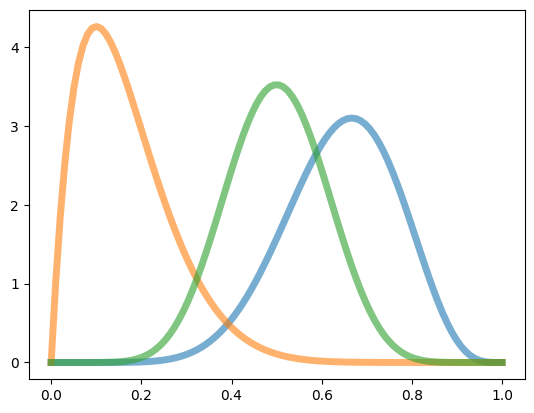

In [106]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

for a, b in [(9, 5), (2, 10), (10, 10)]:
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    print(mean, var, skew, kurt)
    n = 100
    x = np.linspace(0, 1, n)
    y = beta.pdf(x, a, b)
    ax.plot(x, y, '-', lw=5, alpha=0.6, label='beta pdf')

In [ ]:
## input -> source type and persuasion level
##          total num. segments of information
## output -> num. information items to return

In [98]:
y / y.sum()

array([0.02956205, 0.17709205, 0.39757191, 0.34351863, 0.05225535])

In [97]:
x

array([0.33910044, 0.47661662, 0.61413279, 0.75164897, 0.88916514])

In [77]:
from scipy.stats import beta

In [ ]:
rv = beta(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')